# Zheng et al, 2013

Jing Zheng, Su-ping Peng, Ming-chu Liu, Zhe Liang. A novel seismic wavelet estimation method. Journal of Applied Geophysics 90 (2013) 92–95. http://dx.doi.org/10.1016/j.jappgeo.2013.01.007

The authors express the algorithm for a 'single wavelet estimation' like this:

1. Apply an S transform to the seismic data;
2. Get the position of the maximum amplitude in S transform domain as the delay estimation τ^1 and the coarse main frequency estimation ^f s1;
3. Design a filter in the S transform domain with the center point is (τ^1, ^f s1);
4. Apply an inverse S transform to the filtered data which is the output of step 3 and get the data in time domain;
5. Apply FFT to the time domain data;
6. Search the maximum value of the output, and make record of the position as the accurate main frequency estimation ^f ;
7. Reconstruct the Ricker wavelet according to Eq. (1)
8. Estimate the amplitude of the seismic wavelet

We'll leave the multi-component thing alone for now.

## Make data

The authors use isolated reflectors, a Ricker wavelet of 20 Hz, 30 Hz and maybe 40 Hz (the text and figures are not totally consistent), and Gaussian noise at various SNR values measures in dB.

The only tricky part here is computing the correct amount of noise... 

In [1]:
import bruges as bg

dt = 0.001

w, t = bg.filters.ricker(duration=0.128, dt=dt, f=20)

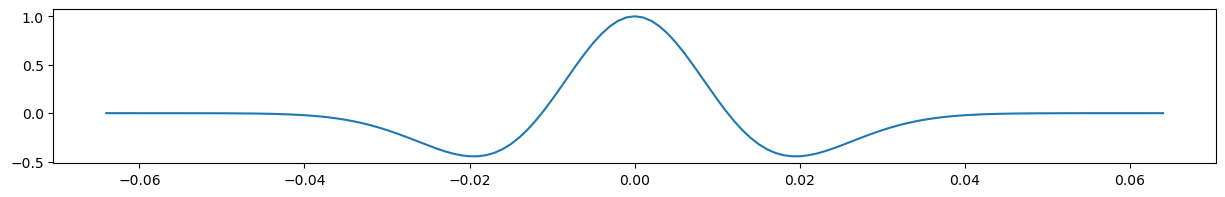

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 2))
plt.plot(t, w)

In [3]:
import numpy as np

# Make the time series in Figure 4.

N = int(0.2 / dt) + 1
r = np.zeros(shape=N)

pos = int(0.05 / dt) + 1
r[pos] = 1

In [4]:
rng = np.random.default_rng(42)
n = rng.normal(loc=0.0, scale=0.25, size=r.size)  # scale is SD, not variance

In [5]:
s = np.convolve(r, w, mode='same') + n

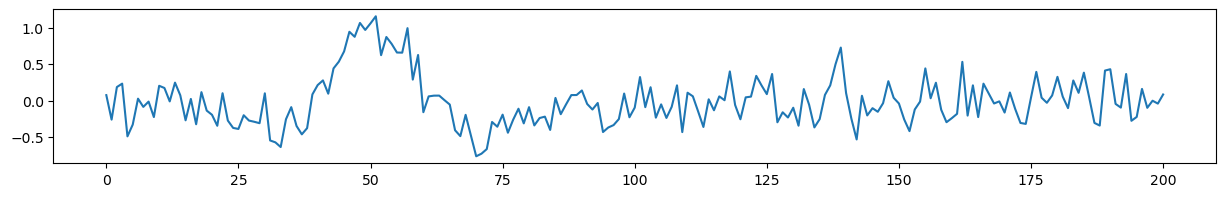

In [6]:
plt.figure(figsize=(15, 2))
plt.plot(s)

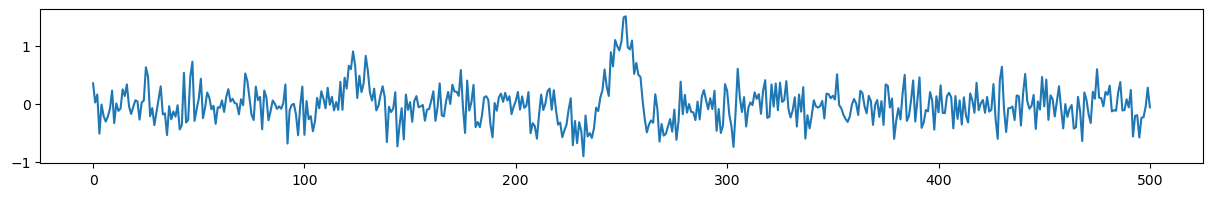

In [7]:
# And in Figure 5.
# Make the time series in Figure 4.

N = int(0.5 / dt) + 1
r = np.zeros(shape=N)

pos1 = int(0.125 / dt) + 1
r[pos1] = 0.5

pos2 = int(0.25 / dt) + 1
r[pos2] = 1

n = rng.normal(loc=0.0, scale=0.25, size=r.size)  # scale is SD, not variance
s_ = np.convolve(r, w, mode='same')
s = s_ + n

plt.figure(figsize=(15, 2))
plt.plot(s)

## 1. Apply an S-transform

We can try using [the `stockwell`package](https://github.com/claudiodsf/stockwell) for the S-transform.

In [8]:
from stockwell import st

t = np.linspace(0, 0.5, s.size)

fmin = 0   # Hz
fmax = 50  # Hz
df = 1. / (t[-1] - t[0])  # Sampling step in frequency domain (Hz).
fmin_samples = int(fmin / df)
fmax_samples = int(fmax / df)
stock = st.st(s, fmin_samples, fmax_samples)

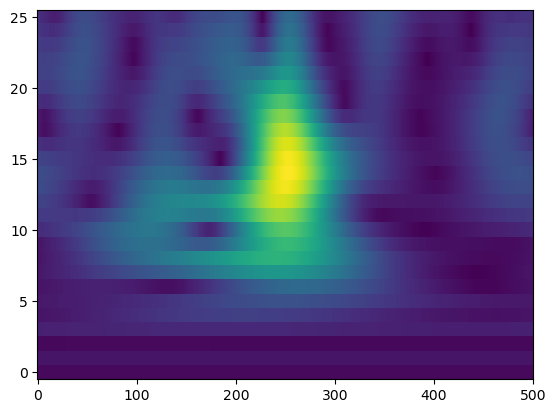

In [9]:
plt.imshow(np.abs(stock), aspect='auto', origin='lower', interpolation='none')

## 2.  Get the position (time, freq) of the maximum amplitude

In [10]:
max_sample = np.argmax(np.abs(stock))

t_max = dt * (max_sample % t.size)
f_max = df * (max_sample // t.size)

f_max

28.0

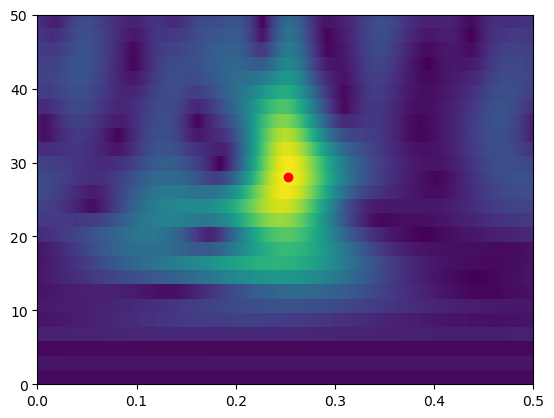

In [11]:
plt.imshow(np.abs(stock), aspect='auto', origin='lower', interpolation='none', extent=[t[0], t[-1], fmin, fmax])
plt.plot(t_max, f_max, 'ro')

## 3. Design (and apply) a filter in the S transform domain

Not sure what this means... what shape? Gaussian? Then how wide? Maybe there's a way to fit a 2D Gaussian but for now I'll just eyeball it.

I assume the idea is to limit how much out-of-band spectrum gets in, and not limit things too much (or at all?) in time. Seems a bit weird to limit in time...

Might explain why the event at 0.125s in Figure 6 appears to be shifted in time.

**I think the text around Figure 7, which appears at first to be in Section 2.2 but is -- I think -- actually part of the main narrative, is important. They seem to threshhold the data at (S_mean plus/minus 2 times S_var) where S is the S-transform.**

In [12]:
# Our 2-dimensional distribution will be over variables t and f.
f = np.linspace(fmin, fmax, (fmax_samples - fmin_samples) + 1)
t_, f_ = np.meshgrid(t, f)

# Mean vector and covariance matrix.
mean = np.array([t_max, f_max])
cov = np.array([[ 0.001 , 0], [0,  100]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(t_.shape + (2,))
pos[:, :, 0] = t_
pos[:, :, 1] = f_

def multivariate_gaussian(pos, mean, cov):
    """
    Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.
    """
    n = mean.shape[0]
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    N = np.sqrt((2*np.pi)**n * cov_det)
    # This einsum call calculates (t-mean)T.cov-1.(t-mean) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos - mean, cov_inv, pos - mean)
    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
z = multivariate_gaussian(pos, mean, cov)
z.shape

(26, 501)

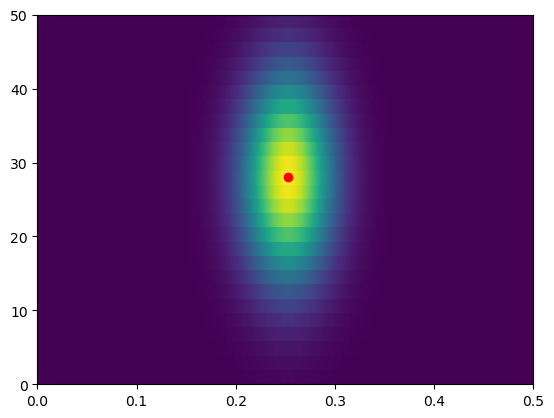

In [13]:
plt.imshow(z, aspect='auto', origin='lower', interpolation='none', extent=[t[0], t[-1], fmin, fmax])
plt.plot(t_max, f_max, 'ro')

Filter the data.

In [14]:
z /= z.max()  # Normalize.

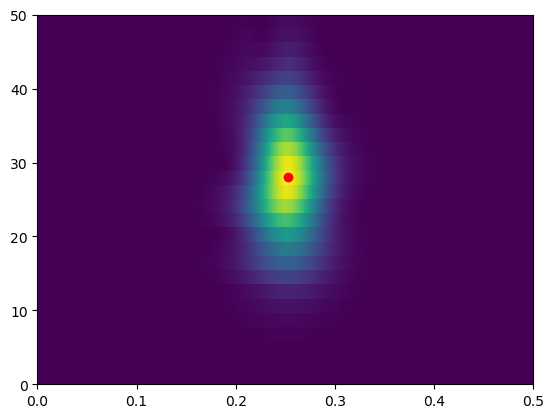

In [15]:
filtered = z * stock  # Use complex spectrum here.

plt.imshow(np.abs(filtered), aspect='auto', origin='lower', interpolation='none', extent=[t[0], t[-1], fmin, fmax])
plt.plot(t_max, f_max, 'ro')

Looks like we have lost a ton of information...

##  4. Apply an inverse S transform to the filtered data

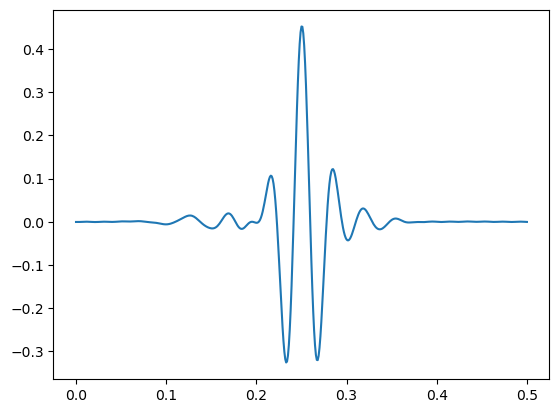

In [16]:
inv_stock = st.ist(filtered, fmin_samples, fmax_samples)

plt.plot(t, inv_stock)

Ugh.

## 5. Apply FFT to the time domain data

In [17]:
# Sampling frequency.
fs = 1 / dt
fs

1000.0

In [18]:
from scipy.signal import welch

freq, Pxx_spec = welch(inv_stock, fs, 'flattop', 256, scaling='spectrum')

## 6. Search the maximum value of the output

In [19]:
f_guess = freq[np.argmax(Pxx_spec)]
f_guess

27.34375

(0.0, 100.0)

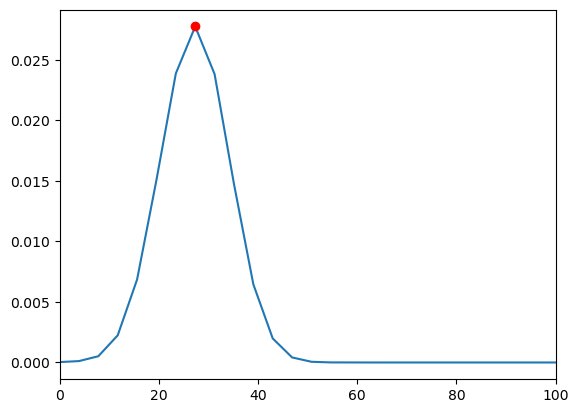

In [20]:
plt.plot(freq, Pxx_spec)
plt.plot(f_guess, Pxx_spec.max(), 'ro')
plt.xlim(0,100)

## 7. Reconstruct the Ricker wavelet

So we end up with a Ricker... this seems simplistic. What if that's a poor fit for the data? We were trying to recover a wavelet from the data, but I guess we're really just estimating the centre frequency. 

It's not a great estimate of that: we got 27 Hz, when I started with a 20 Hz wavelet. Probably depends quite a bit on the "design" step, which felt pretty arbitrary.

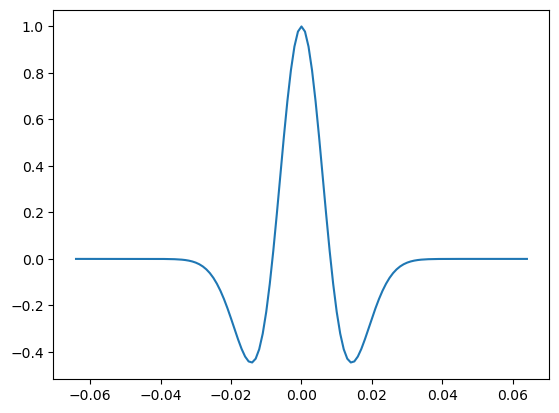

In [21]:
w, t = bg.filters.ricker(duration=0.128, dt=dt, f=f_guess)

plt.plot(t, w)

## Estimate the amplitude of the seismic wavelet

I don't understand the purpose of this step; amplitude doesn't really mean anything at this point.

---

## Conclusion

I don't think there's enough information in this paper to tell exactly what they are doing.

I also don't believe it's a very good way of extracting a wavelet from seismic data. Perhaps I'm missing something, but it seems to make some strong assumptions:

- The paper assumes you are simply trying to parameterize a Ricker. But in general I think you must have a model of the ideal (parametric) wavelet and it has a peak frequency (i.e. is not broadband).
- There is at least one very strong reflector in the data.